In [30]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import pandas as pd 
import seaborn as sns
from scipy.stats import skew
import warnings
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
restaurant_data = pd.read_csv("Restaurant_revenue.csv")

# EDA

In [3]:
restaurant_data.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


In [4]:
restaurant_data.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332


In [5]:
restaurant_data.Cuisine_Type.value_counts()

Japanese    262
American    256
Mexican     250
Italian     232
Name: Cuisine_Type, dtype: int64

<Figure size 1200x400 with 0 Axes>

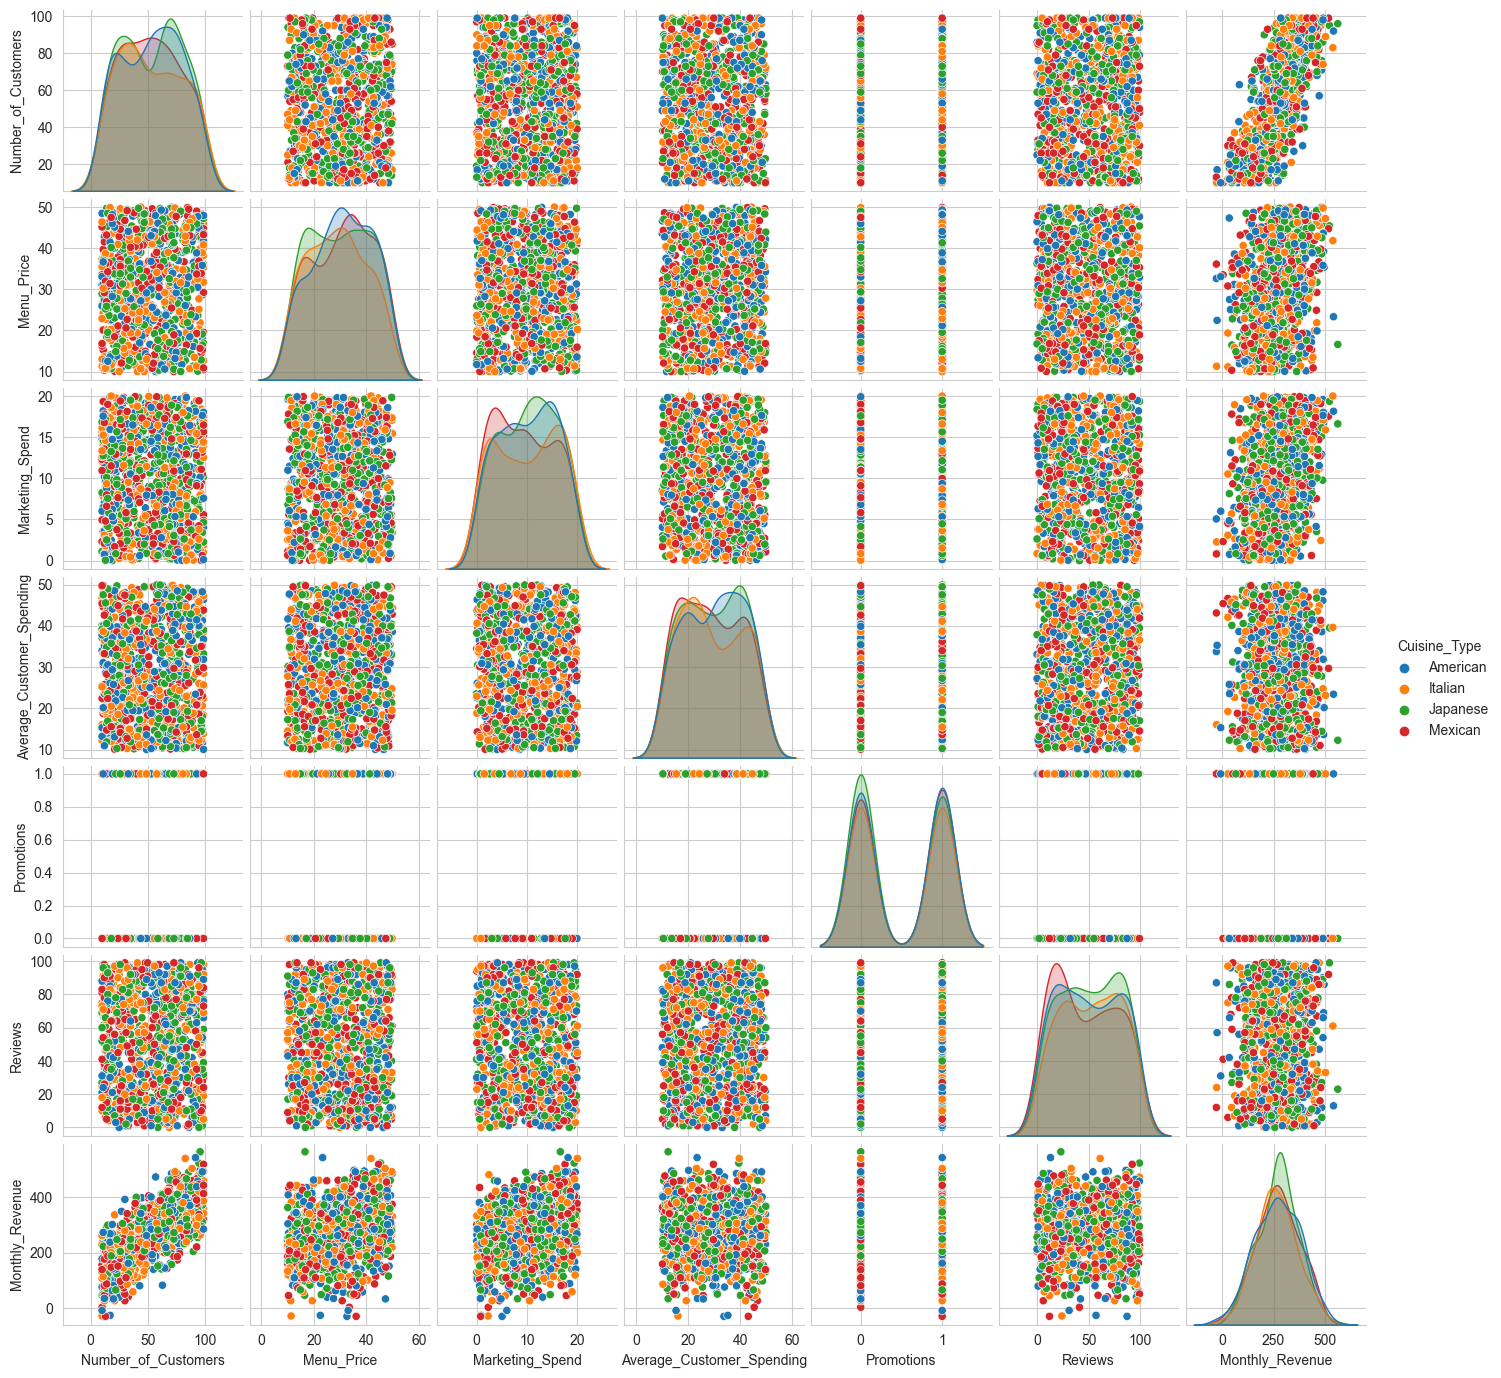

In [6]:
restaurant_data = restaurant_data.loc[:, ~restaurant_data.columns.duplicated()]
required_columns = ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Promotions', 'Reviews','Monthly_Revenue','Cuisine_Type']
missing_columns = [col for col in required_columns if col not in restaurant_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")
training_data_cleaned = restaurant_data.dropna(subset=required_columns)
training_data_cleaned['Cuisine_Type'] = training_data_cleaned['Cuisine_Type'].astype('category')
plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
sns.pairplot(training_data_cleaned[required_columns], height=2, hue='Cuisine_Type')
plt.show()


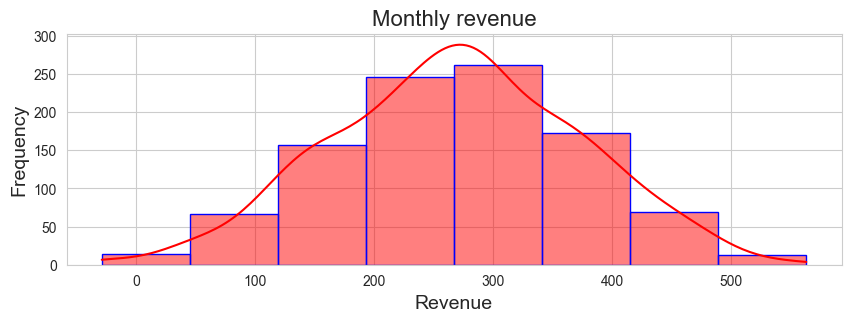

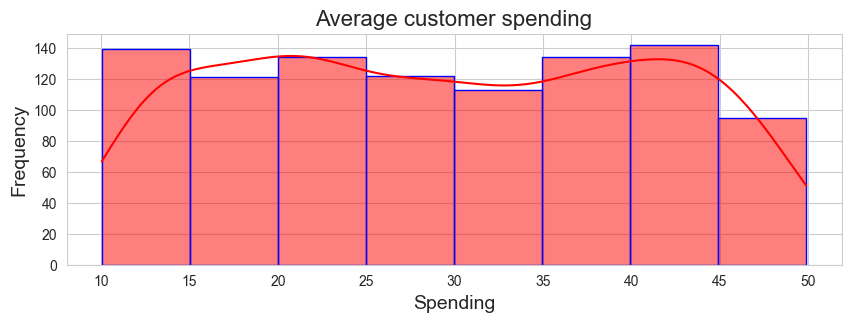

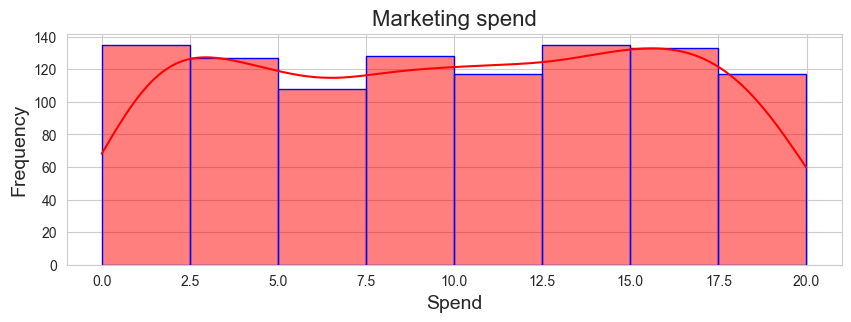

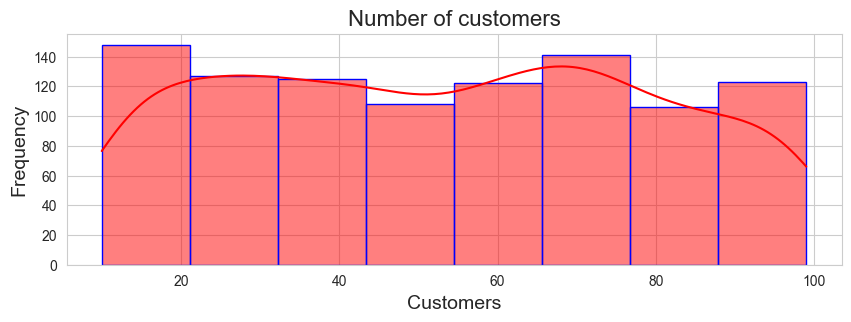

In [7]:



# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Monthly_Revenue']), bins=8, kde=True, color='red', edgecolor='blue')
# Adding title and labels
plt.title('Monthly revenue', fontsize=16)
plt.xlabel('Revenue', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Average_Customer_Spending']), bins=8, kde=True, color='red', edgecolor='blue')
# Adding title and labels
plt.title('Average customer spending', fontsize=16)
plt.xlabel('Spending', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Marketing_Spend']), bins=8, kde=True, color='red', edgecolor='blue')
# Adding title and labels
plt.title('Marketing spend', fontsize=16)
plt.xlabel('Spend', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Number_of_Customers']), bins=8, kde=True, color='red', edgecolor='blue')
# Adding title and labels
plt.title('Number of customers', fontsize=16)
plt.xlabel('Customers', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

# Data preparation

In [8]:
#Function shows percentage of missing values in a dataframe form
def missing_value_percentages(df) :
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    return missing_value_df

In [9]:
#ceating a dataframe that column and missing values percentage
cust_data_missing = missing_value_percentages(restaurant_data)

In [10]:
cust_data_missing

,column_name,percent_missing
Number_of_Customers,Number_of_Customers,0.0
Menu_Price,Menu_Price,0.0
Marketing_Spend,Marketing_Spend,0.0
Cuisine_Type,Cuisine_Type,0.0
Average_Customer_Spending,Average_Customer_Spending,0.0
Promotions,Promotions,0.0
Reviews,Reviews,0.0
Monthly_Revenue,Monthly_Revenue,0.0


In [11]:
#A function that detects the skewness of the data
def skewness_detector(dataset,col):
    skewness = skew(dataset[col])
    if skewness > 0:
        return "left-skewed"
    elif skewness < 0:
        return "left-skewed"
    else:
        return "symmetrical"

In [12]:
numeric_columns = restaurant_data.select_dtypes(include=['number']).columns

In [13]:
print(list(numeric_columns))

['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Promotions', 'Reviews', 'Monthly_Revenue']


In [14]:
cols_skewness = pd.DataFrame()
for column in numeric_columns:
    skewness = skewness_detector(restaurant_data,column)
    row = {'column':column,'skewness':skewness}
    cols_skewness = cols_skewness.append(row, ignore_index=True)
cols_skewness

,column,skewness
0,Number_of_Customers,left-skewed
1,Menu_Price,left-skewed
2,Marketing_Spend,left-skewed
3,Average_Customer_Spending,left-skewed
4,Promotions,left-skewed
5,Reviews,left-skewed
6,Monthly_Revenue,left-skewed


In [15]:
#Function that removes outliers IQR, used for normally left/right skewed data
def remove_outliers_iqr(data_frame,cols):
    cleaned_df = data_frame.copy()
    for column_name in cols:
        Q1 = cleaned_df[column_name].quantile(0.25)
        Q3 = cleaned_df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[column_name] >= lower_bound) & (cleaned_df[column_name] <= upper_bound)]
    return cleaned_df

In [16]:
restaurant_data_wou = remove_outliers_iqr(restaurant_data,numeric_columns)

In [17]:
restaurant_data_wou.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,53.390955,30.251232,9.983004,29.483983,0.495477,49.883417,269.619853
std,26.270090,11.278393,5.834981,11.469257,0.500231,29.226626,102.102873
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-7.627382
25%,30.500000,20.478343,4.708948,19.641153,0.000000,24.000000,198.351905
50%,54.000000,30.869202,10.148927,29.211770,0.000000,50.000000,270.513361
75%,74.000000,39.894946,14.993962,39.556699,1.000000,76.000000,343.428722
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,542.467282


In [18]:
has_duplicates = restaurant_data_wou.duplicated().any()

if has_duplicates:
    print("DataFrame has duplicates.")
else:
    print("DataFrame has no duplicates.")

# Get duplicate counts
duplicate_counts = restaurant_data_wou.duplicated().sum()

print("Number of duplicate rows:", duplicate_counts)
restaurant_data_wou = restaurant_data_wou.drop_duplicates()

DataFrame has no duplicates.
Number of duplicate rows: 0


In [21]:
restaurant_data_wou = pd.get_dummies(restaurant_data_wou, columns=['Cuisine_Type']) 

#### Feature selection

In [22]:
X = restaurant_data_wou.drop(columns=['Monthly_Revenue'])
y = restaurant_data_wou['Monthly_Revenue']

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [27]:
# Apply Variance Threshold to the training and testing sets
X_train_var = variance_threshold_selector(X_train, threshold=0.01)
X_test_var = variance_threshold_selector(X_test, threshold=0.01)

In [28]:
# Feature Selection using Variance Threshold
def variance_threshold_selector(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    return selector.fit_transform(data)

# Apply Variance Threshold to the training and testing sets
X_train_var = variance_threshold_selector(X_train, threshold=0.01)
X_test_var = variance_threshold_selector(X_test, threshold=0.01)

# Feature Selection using Correlation Coefficient
def correlation_coefficient_selector(X, y, threshold=0.1):
    selected_features = []
    for i in range(X.shape[1]):
        corr, _ = pearsonr(X[:, i], y)
        if abs(corr) >= threshold:
            selected_features.append(i)
    return selected_features

In [32]:
# Get the selected feature indices based on correlation coefficient
selected_features = correlation_coefficient_selector(X_train_var, y_train, threshold=0.2)

In [33]:
# Train MLP Regressor with selected features
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)

print(f'Selected Features Indices: {selected_features}')
print(f'Mean Squared Error: {mse}')

NameError: name 'X_train_selected' is not defined